# Projeto - Mineração de Texto e Web
## Residência Engenharia e Ciência de dados - Samsung/UFPE

### Lucas Couri - lncc2
### Mariama Oliveira - mcso

## Carregando Dados

In [1]:
#Imports
import string
import nltk
from nltk.corpus import stopwords
import pandas as pd
# from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.sparse import csr_matrix
from scipy.cluster.vq import vq

import numpy as np
import tensorflow as tf
#from keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Conv2D, Input
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

import dataset_split 
import networks
import bert
import rm_forest

In [2]:
df = pd.read_csv("reviews_v2.csv")
df = df[df["reviews"].notna()]

## Pré-processamento (com e sem stemming)

In [3]:
#Global variables
other_punctuation = '—“”'  
stop_words = stopwords.words('portuguese')
stop_words.append('’')
stemmer = nltk.stem.RSLPStemmer()


#Function that removes punctuation 
def remove_punctuation(text):
    punctuation_free_doc = "".join([i for i in text if i not in string.punctuation+other_punctuation])
    return punctuation_free_doc


def remove_stopwords(list_words):
    filtered_words = [word for word in list_words if word not in stop_words]
    return filtered_words


def do_stemming(list_words):
    stem_text = [stemmer.stem(word) for word in list_words]
    return stem_text


def pre_process(doc, basic_processing = False, no_stopwords = False, stemming = False):

    final_doc = doc
    
    ## print(final_doc)

    if basic_processing == True:
        
        final_doc = remove_punctuation(doc)
        final_doc = final_doc.lower()

    final_doc = nltk.word_tokenize(final_doc)

    if no_stopwords == True:
        final_doc = remove_stopwords(final_doc)    

    if stemming == True:
        final_doc = do_stemming(final_doc)

    return final_doc

def pre_process_all(df, pre_processing_list):

    for param, index in zip(pre_processing_list, range(len(pre_processing_list))):
        
        df[f"reviews_pipeline_{index}"] = df["reviews"].apply(lambda x: pre_process(x, **param))

    return df

pre_processing_list = [
    {"basic_processing": True, "no_stopwords": True, "stemming": False},
    {"basic_processing": True, "no_stopwords": True, "stemming": True}]

df_pp = pre_process_all(df, pre_processing_list)

## Definindo classe

In [4]:
df_pp["class"] = df_pp["stars"].apply(lambda x : 1 if x >=4 else 0)

## Divisão Train, Validation e Test

In [5]:
#Unbalanced dataset
X_train, X_valid, X_test, y_train, y_valid, y_test = dataset_split.split_data(df_pp)

#Balanced dataset
X_train_b, X_valid_b, X_test_b, y_train_b, y_valid_b, y_test_b = dataset_split.split_data(df_pp, True)

Transformando tokens em string

In [6]:
def tokens_to_string(df):
    X_train_join = []
    X_train_join.append(df["reviews_pipeline_0"].apply(" ".join))
    X_train_join.append(df["reviews_pipeline_1"].apply(" ".join))
    X_train_join[0] = X_train_join[0].to_numpy()
    X_train_join[1] = X_train_join[1].to_numpy()

    return X_train_join

In [7]:
#Unbalanced data
X_train_join = tokens_to_string(X_train)
X_test_join = tokens_to_string(X_test)
X_valid_join = tokens_to_string(X_valid)

#Balanced data
X_train_join_b = tokens_to_string(X_train_b)
X_test_join_b = tokens_to_string(X_test_b)
X_valid_join_b = tokens_to_string(X_valid_b)


# Classificadores 

In [8]:
all_metrics = []

def calc_metrics(y_test, result, name):
    f1_w = f1_0 = f1_score(y_test, result, average="weighted")
    f1_0 = f1_score(y_test, result, average=None)[0]
    f1_1 = f1_score(y_test, result, average=None)[1]
    acc = accuracy_score(y_test, result)
    return (name, acc, f1_0, f1_1, f1_w, result.tolist())


## Random Forest com BoW

In [9]:
def get_bag_of_words(X_train_join, X_valid_join, X_test_join):
    vectorizer = CountVectorizer(analyzer = "word",   
                                tokenizer = None,    
                                preprocessor = None, 
                                stop_words = None,   
                                max_features = 1500) 

    #List with BoWs (pipeline 0 and 1)
    X_train_vec = []
    X_train_vec.append(vectorizer.fit_transform(X_train_join[0]))
    X_train_vec.append(vectorizer.fit_transform(X_train_join[1]))

    X_test_vec = []
    X_test_vec.append(vectorizer.fit_transform(X_test_join[0]))
    X_test_vec.append(vectorizer.fit_transform(X_test_join[1]))

    X_valid_vec = []
    X_valid_vec.append(vectorizer.fit_transform(X_valid_join[0]))
    X_valid_vec.append(vectorizer.fit_transform(X_valid_join[1]))


    return X_train_vec, X_valid_vec, X_test_vec

In [10]:
#Unbalanced data
X_train_vec, X_valid_vec, X_test_vec = get_bag_of_words(X_train_join, X_valid_join, X_test_join)

#Balanced data
X_train_vec_b, X_valid_vec_b, X_test_vec_b = get_bag_of_words(X_train_join_b, X_valid_join_b, X_test_join_b)

In [11]:
def pipeline_rf(name, X_train_vec, y_train, X_valid_vec, y_valid, X_test_vec, y_test):
    #Get best parameters
    best_params = rm_forest.get_best_parameters(X_train_vec, X_valid_vec, y_train, y_valid)
    
    #Train model with best parameters
    forest = RandomForestClassifier(**best_params) 
    forest = forest.fit(X_train_vec, y_train)

    #Predict test datase 
    result = forest.predict(X_test_vec)
    print(classification_report(y_test, result))
    print(confusion_matrix(y_test, result))

    metrics = calc_metrics(y_test, result, name)

    return metrics

### Sem stemming

In [12]:
#Unbalanced data
all_metrics.append(pipeline_rf("rf", X_train_vec[0], y_train, X_valid_vec[0], y_valid, X_test_vec[0], y_test))

[I 2022-03-31 18:59:19,134] A new study created in memory with name: no-name-926fa226-f533-4d5d-a6bd-cb57297d1898
[I 2022-03-31 18:59:19,201] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 39, 'max_depth': 4, 'criterion': 'entropy'}. Best is trial 0 with value: 0.0.
[I 2022-03-31 18:59:20,069] Trial 1 finished with value: 0.16363636363636364 and parameters: {'n_estimators': 225, 'max_depth': 51, 'criterion': 'gini'}. Best is trial 1 with value: 0.16363636363636364.
[I 2022-03-31 18:59:21,071] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 364, 'max_depth': 23, 'criterion': 'entropy'}. Best is trial 1 with value: 0.16363636363636364.
[I 2022-03-31 18:59:22,697] Trial 3 finished with value: 0.07207207207207207 and parameters: {'n_estimators': 454, 'max_depth': 41, 'criterion': 'gini'}. Best is trial 1 with value: 0.16363636363636364.
[I 2022-03-31 18:59:23,069] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 261, 'max_depth': 4, 'cr

              precision    recall  f1-score   support

           0       0.21      0.12      0.15       167
           1       0.90      0.94      0.92      1334

    accuracy                           0.85      1501
   macro avg       0.55      0.53      0.53      1501
weighted avg       0.82      0.85      0.83      1501

[[  20  147]
 [  77 1257]]


In [13]:
#Balanced data
all_metrics.append(pipeline_rf("rf_b",X_train_vec_b[0], y_train_b, X_valid_vec_b[0], y_valid_b, X_test_vec_b[0], y_test_b))

[I 2022-03-31 19:00:08,670] A new study created in memory with name: no-name-80cf0708-08af-42cc-8527-5e2f28c9d29f
[I 2022-03-31 19:00:08,690] Trial 0 finished with value: 0.022222222222222223 and parameters: {'n_estimators': 7, 'max_depth': 7, 'criterion': 'gini'}. Best is trial 0 with value: 0.022222222222222223.
[I 2022-03-31 19:00:09,125] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 247, 'max_depth': 11, 'criterion': 'gini'}. Best is trial 0 with value: 0.022222222222222223.
[I 2022-03-31 19:00:09,336] Trial 2 finished with value: 0.11612903225806452 and parameters: {'n_estimators': 43, 'max_depth': 56, 'criterion': 'gini'}. Best is trial 2 with value: 0.11612903225806452.
[I 2022-03-31 19:00:10,904] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 941, 'max_depth': 9, 'criterion': 'entropy'}. Best is trial 2 with value: 0.11612903225806452.
[I 2022-03-31 19:00:11,168] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 179, 'max_d

              precision    recall  f1-score   support

           0       0.20      0.11      0.14       167
           1       0.89      0.94      0.92      1334

    accuracy                           0.85      1501
   macro avg       0.55      0.53      0.53      1501
weighted avg       0.82      0.85      0.83      1501

[[  19  148]
 [  77 1257]]


### Com stemming

In [14]:
all_metrics.append(pipeline_rf("rf_st",X_train_vec[1], y_train, X_valid_vec[1], y_valid, X_test_vec[1], y_test))

[I 2022-03-31 19:00:58,050] A new study created in memory with name: no-name-b0401a04-4e34-434c-ba26-fd16fd75ceb4
[I 2022-03-31 19:00:59,236] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 813, 'max_depth': 5, 'criterion': 'entropy'}. Best is trial 0 with value: 0.0.
[I 2022-03-31 19:01:00,167] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 405, 'max_depth': 21, 'criterion': 'gini'}. Best is trial 0 with value: 0.0.
[I 2022-03-31 19:01:01,363] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 938, 'max_depth': 2, 'criterion': 'entropy'}. Best is trial 0 with value: 0.0.
[I 2022-03-31 19:01:03,524] Trial 3 finished with value: 0.09433962264150943 and parameters: {'n_estimators': 366, 'max_depth': 117, 'criterion': 'entropy'}. Best is trial 3 with value: 0.09433962264150943.
[I 2022-03-31 19:01:05,270] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 704, 'max_depth': 18, 'criterion': 'entropy'}. Best is trial 3 with 

              precision    recall  f1-score   support

           0       0.23      0.14      0.18       167
           1       0.90      0.94      0.92      1334

    accuracy                           0.85      1501
   macro avg       0.56      0.54      0.55      1501
weighted avg       0.82      0.85      0.84      1501

[[  24  143]
 [  81 1253]]


In [17]:
all_metrics.append(pipeline_rf("rf_b_st",X_train_vec_b[1], y_train_b, X_valid_vec_b[1], y_valid_b, X_test_vec_b[1], y_test_b))

[I 2022-03-31 19:01:45,001] A new study created in memory with name: no-name-ef573c75-4d95-415b-a904-ec2deed71bdf
[I 2022-03-31 19:01:46,402] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 930, 'max_depth': 6, 'criterion': 'gini'}. Best is trial 0 with value: 0.0.
[I 2022-03-31 19:01:46,708] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 146, 'max_depth': 10, 'criterion': 'entropy'}. Best is trial 0 with value: 0.0.
[I 2022-03-31 19:01:47,393] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 194, 'max_depth': 21, 'criterion': 'entropy'}. Best is trial 0 with value: 0.0.
[I 2022-03-31 19:01:49,494] Trial 3 finished with value: 0.1324503311258278 and parameters: {'n_estimators': 340, 'max_depth': 61, 'criterion': 'gini'}. Best is trial 3 with value: 0.1324503311258278.
[I 2022-03-31 19:01:50,761] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 923, 'max_depth': 4, 'criterion': 'gini'}. Best is trial 3 with value: 0.

              precision    recall  f1-score   support

           0       0.18      0.16      0.17       167
           1       0.90      0.91      0.90      1334

    accuracy                           0.83      1501
   macro avg       0.54      0.54      0.54      1501
weighted avg       0.82      0.83      0.82      1501

[[  27  140]
 [ 122 1212]]


In [18]:
df_metrics = pd.DataFrame(all_metrics, columns=['name', 'accuracy', 'f1_0', 'f1_1', 'f1_w','predictions'])
df_metrics.to_csv("metrics_bow.csv", index= False)

## Redes (CNN, LSTM e BERT)

In [16]:
def pipeline_cnn_lstm(tuner_name,X_train, y_train, X_valid, y_valid, X_test, y_test):

    type_nn = tuner_name[:3]
   
    #Encoding sentences
    encoder = networks.sentence_encoder(X_train)

    #Finding best parameters
    tuner = networks.network_tuner(type_nn, encoder, tuner_name)
    
    best_hp = networks.search_network(tuner, X_train, y_train, X_valid, y_valid)

    #Loading best model
    model = networks.get_model(tuner, best_hp)
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    history = model.fit(X_train, y_train, epochs=50, validation_data = (X_valid, y_valid), callbacks=[stop_early])

    #Getting test results
    result = networks.get_test_metrics(model, X_test, y_test)
    networks.plot_acuracy_loss(history)

    metrics = calc_metrics(y_test, result, tuner_name)
    return metrics

### CNN

#### Sem stemming

INFO:tensorflow:Reloading Oracle from existing project tuner\cnn\oracle.json
INFO:tensorflow:Reloading Tuner from tuner\cnn\tuner0.json
Search space summary
Default search space size: 2
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
None
INFO:tensorflow:Oracle triggered exit
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          16416     
________________________________________________________

C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


88/88 [==============================] - ETA: 0s - loss: 0.3062 - accuracy: 0.8958

C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


88/88 [==============================] - 11s 92ms/step - loss: 0.3062 - accuracy: 0.8958 - val_loss: 0.2569 - val_accuracy: 0.9087
Epoch 2/50
88/88 [==============================] - 2s 22ms/step - loss: 0.1648 - accuracy: 0.9340 - val_loss: 0.2696 - val_accuracy: 0.8887
Epoch 3/50
88/88 [==============================] - 1s 11ms/step - loss: 0.0832 - accuracy: 0.9718 - val_loss: 0.3051 - val_accuracy: 0.8944
Epoch 4/50
88/88 [==============================] - 1s 12ms/step - loss: 0.0406 - accuracy: 0.9854 - val_loss: 0.4327 - val_accuracy: 0.8859
Epoch 5/50
88/88 [==============================] - 1s 9ms/step - loss: 0.0127 - accuracy: 0.9961 - val_loss: 0.5756 - val_accuracy: 0.8930
Epoch 6/50
47/47 [==============================] - 1s 24ms/step - loss: 0.6107 - accuracy: 0.8774
Test Loss: 0.6107040047645569
Test Accuracy: 0.8774150609970093
              precision    recall  f1-score   support

           0       0.45      0.43      0.44       167
           1       0.93      0.93 

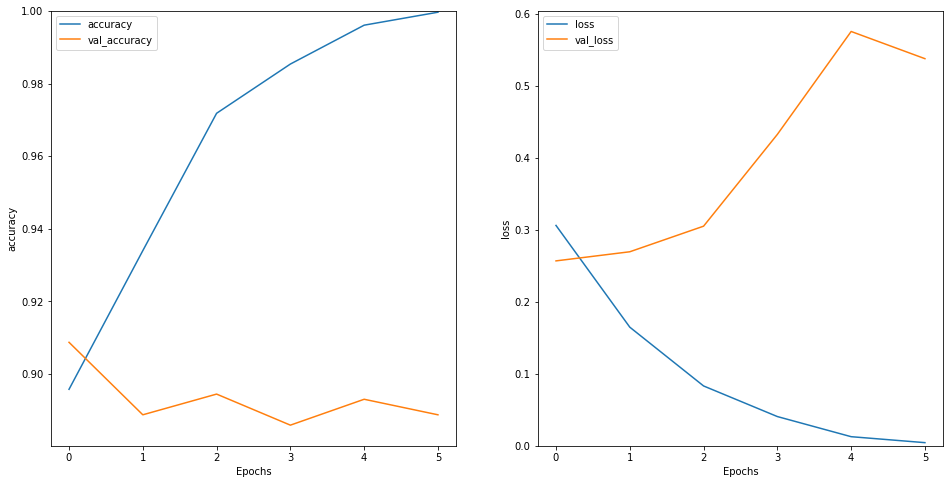

In [19]:
# Desbalanceado
all_metrics.append(pipeline_cnn_lstm("cnn",X_train_join[0], y_train, X_valid_join[0], y_valid, X_test_join[0], y_test))

Trial 31 Complete [00h 00m 03s]
val_accuracy: 0.8887304067611694

Best val_accuracy So Far: 0.9186875820159912
Total elapsed time: 00h 01m 56s
INFO:tensorflow:Oracle triggered exit


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          16416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


104/104 [==============================] - 2s 11ms/step - loss: 0.5341 - accuracy: 0.7395 - val_loss: 0.4462 - val_accuracy: 0.8716
Epoch 2/50
104/104 [==============================] - 1s 10ms/step - loss: 0.3340 - accuracy: 0.8717 - val_loss: 0.2738 - val_accuracy: 0.8987
Epoch 3/50
104/104 [==============================] - 1s 9ms/step - loss: 0.1823 - accuracy: 0.9355 - val_loss: 0.2440 - val_accuracy: 0.9058
Epoch 4/50
104/104 [==============================] - 1s 9ms/step - loss: 0.1013 - accuracy: 0.9699 - val_loss: 0.2419 - val_accuracy: 0.9158
Epoch 5/50
104/104 [==============================] - 1s 10ms/step - loss: 0.0628 - accuracy: 0.9831 - val_loss: 0.2569 - val_accuracy: 0.9087
Epoch 6/50
104/104 [==============================] - 1s 11ms/step - loss: 0.0389 - accuracy: 0.9928 - val_loss: 0.2839 - val_accuracy: 0.9101
Epoch 7/50
104/104 [==============================] - 1s 11ms/step - loss: 0.0255 - accuracy: 0.9952 - val_loss: 0.3086 - val_accuracy: 0.9058
Epoch 8/50
1

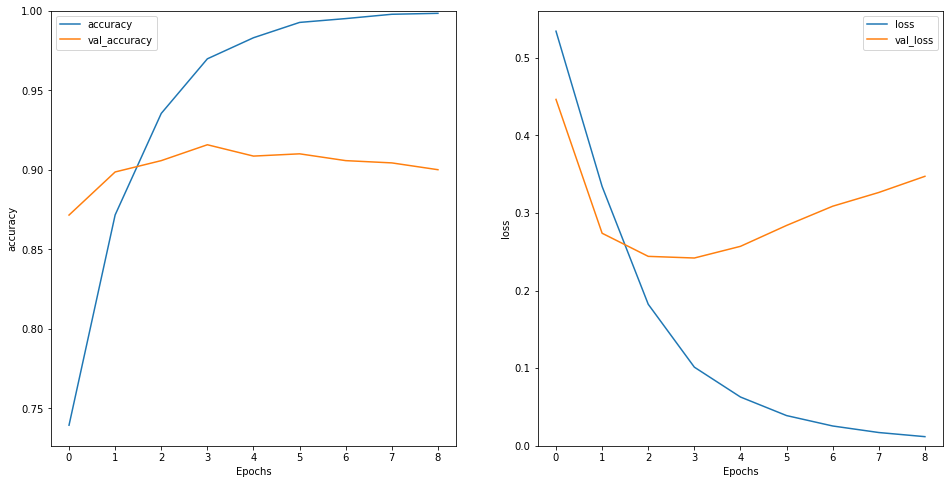

In [20]:
# Balanceado
all_metrics.append(pipeline_cnn_lstm("cnn_b",X_train_join_b[0], y_train_b, X_valid_join_b[0], y_valid_b, X_test_join_b[0], y_test_b))

#### Com stemming

Trial 33 Complete [00h 00m 03s]
val_accuracy: 0.8887304067611694

Best val_accuracy So Far: 0.9172610640525818
Total elapsed time: 00h 01m 55s
INFO:tensorflow:Oracle triggered exit


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          16416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


88/88 [==============================] - 2s 12ms/step - loss: 0.2949 - accuracy: 0.8954 - val_loss: 0.2472 - val_accuracy: 0.9087
Epoch 2/50
88/88 [==============================] - 1s 10ms/step - loss: 0.1511 - accuracy: 0.9454 - val_loss: 0.2982 - val_accuracy: 0.8902
Epoch 3/50
88/88 [==============================] - 1s 10ms/step - loss: 0.0601 - accuracy: 0.9804 - val_loss: 0.3643 - val_accuracy: 0.8887
Epoch 4/50
88/88 [==============================] - 1s 11ms/step - loss: 0.0164 - accuracy: 0.9968 - val_loss: 0.4965 - val_accuracy: 0.9073
Epoch 5/50
88/88 [==============================] - 1s 8ms/step - loss: 0.0048 - accuracy: 0.9986 - val_loss: 0.5666 - val_accuracy: 0.9016
Epoch 6/50
47/47 [==============================] - 0s 4ms/step - loss: 0.5323 - accuracy: 0.8894
Test Loss: 0.5322619676589966
Test Accuracy: 0.8894070386886597
              precision    recall  f1-score   support

           0       0.50      0.37      0.42       167
           1       0.92      0.96   

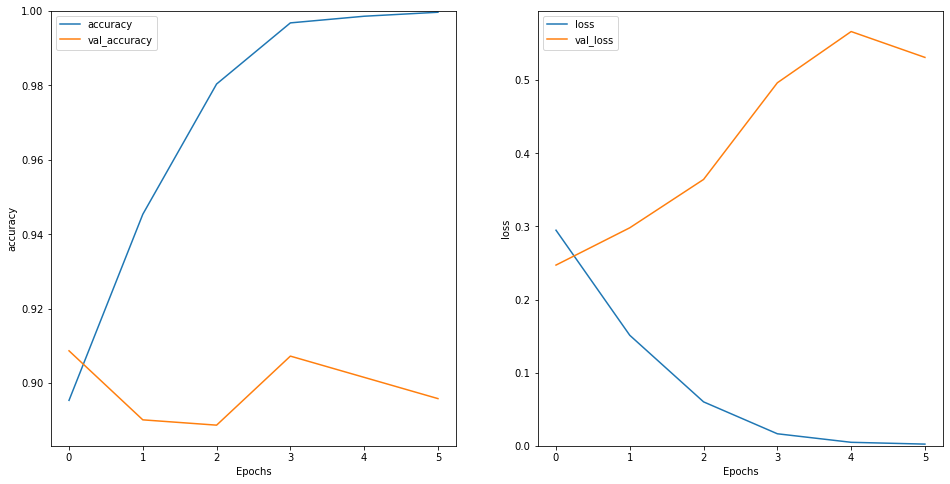

In [21]:
#Desbalanceado
all_metrics.append(pipeline_cnn_lstm("cnn_st",X_train_join[1], y_train, X_valid_join[1], y_valid, X_test_join[1], y_test))

Trial 33 Complete [00h 00m 03s]
val_accuracy: 0.8887304067611694

Best val_accuracy So Far: 0.9129814505577087
Total elapsed time: 00h 02m 04s
INFO:tensorflow:Oracle triggered exit


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          16416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


104/104 [==============================] - 2s 12ms/step - loss: 0.3127 - accuracy: 0.8627 - val_loss: 0.2859 - val_accuracy: 0.8730
Epoch 2/50
104/104 [==============================] - 1s 9ms/step - loss: 0.1206 - accuracy: 0.9533 - val_loss: 0.3357 - val_accuracy: 0.8859
Epoch 3/50
104/104 [==============================] - 1s 10ms/step - loss: 0.0503 - accuracy: 0.9813 - val_loss: 0.3634 - val_accuracy: 0.8944
Epoch 4/50
104/104 [==============================] - 1s 10ms/step - loss: 0.0266 - accuracy: 0.9910 - val_loss: 0.5089 - val_accuracy: 0.8987
Epoch 5/50
104/104 [==============================] - 1s 8ms/step - loss: 0.0374 - accuracy: 0.9858 - val_loss: 0.5586 - val_accuracy: 0.8902
Epoch 6/50
47/47 [==============================] - 0s 5ms/step - loss: 0.7711 - accuracy: 0.8921
Test Loss: 0.7711418867111206
Test Accuracy: 0.8920719623565674
              precision    recall  f1-score   support

           0       0.53      0.29      0.37       167
           1       0.92    

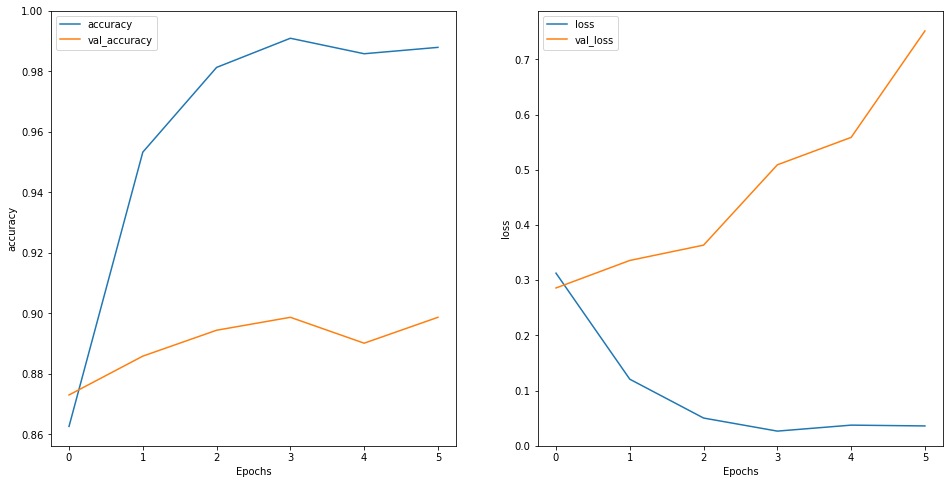

In [22]:
#Balanceado
all_metrics.append(pipeline_cnn_lstm("cnn_b_st",X_train_join_b[1], y_train_b, X_valid_join_b[1], y_valid_b, X_test_join_b[1], y_test_b))

In [23]:
df_metrics = pd.DataFrame(all_metrics, columns=['name', 'accuracy', 'f1_0', 'f1_1', 'f1_w','predictions'])
df_metrics.to_csv("metrics_cnn.csv", index= False)

### LSTM

#### Sem stemming

Trial 32 Complete [00h 00m 19s]
val_accuracy: 0.9058488011360168

Best val_accuracy So Far: 0.9087018370628357
Total elapsed time: 00h 10m 27s
INFO:tensorflow:Oracle triggered exit


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 130,177
Trainable params: 130,177
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
88/88 [==============================] - ETA: 0s - loss: 0.4062 - accuracy: 0.8825

C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


88/88 [==============================] - 13s 55ms/step - loss: 0.4062 - accuracy: 0.8825 - val_loss: 0.2929 - val_accuracy: 0.8873
Epoch 2/50
88/88 [==============================] - 3s 30ms/step - loss: 0.2278 - accuracy: 0.9118 - val_loss: 0.2476 - val_accuracy: 0.9058
Epoch 3/50
88/88 [==============================] - 3s 29ms/step - loss: 0.1622 - accuracy: 0.9375 - val_loss: 0.2542 - val_accuracy: 0.8944
Epoch 4/50
88/88 [==============================] - 3s 29ms/step - loss: 0.1302 - accuracy: 0.9532 - val_loss: 0.2811 - val_accuracy: 0.8959
Epoch 5/50
88/88 [==============================] - 3s 29ms/step - loss: 0.1118 - accuracy: 0.9597 - val_loss: 0.3507 - val_accuracy: 0.8859
Epoch 6/50
88/88 [==============================] - 3s 29ms/step - loss: 0.0843 - accuracy: 0.9732 - val_loss: 0.4082 - val_accuracy: 0.8873
Epoch 7/50
47/47 [==============================] - 0s 10ms/step - loss: 0.4394 - accuracy: 0.8694
Test Loss: 0.4394463002681732
Test Accuracy: 0.8694204092025757
 

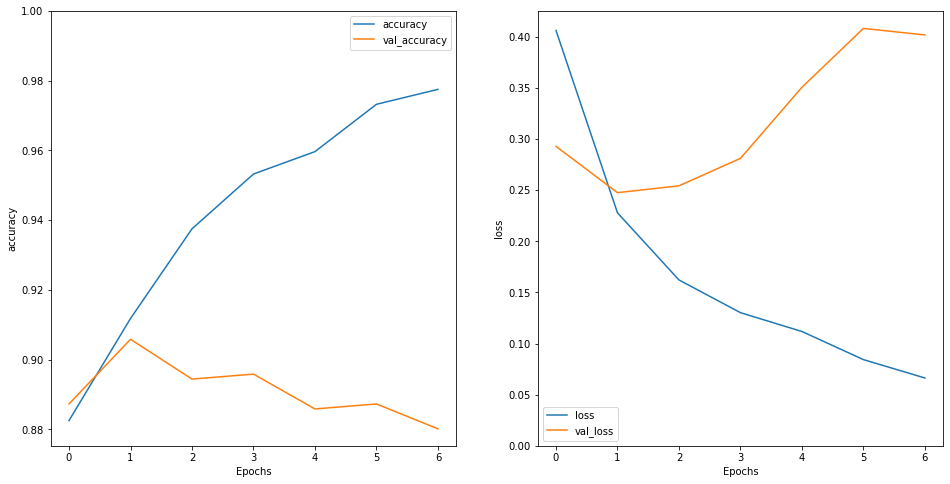

In [24]:
# Desbalanceado
all_metrics.append(pipeline_cnn_lstm("lstm",X_train_join[0], y_train, X_valid_join[0], y_valid, X_test_join[0], y_test))

Trial 27 Complete [00h 00m 20s]
val_accuracy: 0.9087018370628357

Best val_accuracy So Far: 0.9115549325942993
Total elapsed time: 00h 09m 04s
INFO:tensorflow:Oracle triggered exit


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 130,177
Trainable params: 130,177
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
104/104 [==============================] - ETA: 0s - loss: 0.4682 - accuracy: 0.7898

C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


104/104 [==============================] - 14s 55ms/step - loss: 0.4682 - accuracy: 0.7898 - val_loss: 0.2535 - val_accuracy: 0.9001
Epoch 2/50
104/104 [==============================] - 3s 29ms/step - loss: 0.2129 - accuracy: 0.9175 - val_loss: 0.2528 - val_accuracy: 0.8973
Epoch 3/50
104/104 [==============================] - 3s 29ms/step - loss: 0.1272 - accuracy: 0.9560 - val_loss: 0.3293 - val_accuracy: 0.8930
Epoch 4/50
104/104 [==============================] - 3s 29ms/step - loss: 0.0873 - accuracy: 0.9705 - val_loss: 0.4002 - val_accuracy: 0.8802
Epoch 5/50
104/104 [==============================] - 3s 28ms/step - loss: 0.0630 - accuracy: 0.9777 - val_loss: 0.4610 - val_accuracy: 0.8916
Epoch 6/50
104/104 [==============================] - 3s 29ms/step - loss: 0.0401 - accuracy: 0.9889 - val_loss: 0.4633 - val_accuracy: 0.9044
Epoch 7/50
47/47 [==============================] - 1s 11ms/step - loss: 0.6736 - accuracy: 0.8867
Test Loss: 0.6736061573028564
Test Accuracy: 0.886742

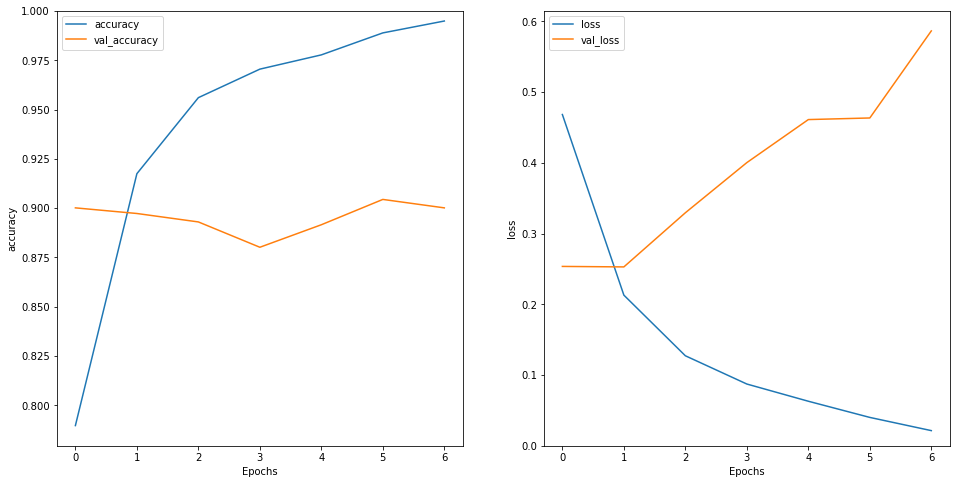

In [25]:
# Balanceado
all_metrics.append(pipeline_cnn_lstm("lstm_b",X_train_join_b[0], y_train_b, X_valid_join_b[0], y_valid_b, X_test_join_b[0], y_test_b))

#### Com stemming

Trial 29 Complete [00h 00m 19s]
val_accuracy: 0.8887304067611694

Best val_accuracy So Far: 0.9144079685211182
Total elapsed time: 00h 09m 29s
INFO:tensorflow:Oracle triggered exit


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 130,177
Trainable params: 130,177
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
86/88 [============================>.] - ETA: 0s - loss: 0.2984 - accuracy: 0.8892

C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


88/88 [==============================] - 13s 56ms/step - loss: 0.2961 - accuracy: 0.8900 - val_loss: 0.2544 - val_accuracy: 0.9087
Epoch 2/50
88/88 [==============================] - 3s 30ms/step - loss: 0.1858 - accuracy: 0.9304 - val_loss: 0.2657 - val_accuracy: 0.8973
Epoch 3/50
88/88 [==============================] - 3s 28ms/step - loss: 0.1353 - accuracy: 0.9472 - val_loss: 0.2970 - val_accuracy: 0.8916
Epoch 4/50
88/88 [==============================] - 3s 30ms/step - loss: 0.0846 - accuracy: 0.9704 - val_loss: 0.3923 - val_accuracy: 0.8730
Epoch 5/50
88/88 [==============================] - 3s 30ms/step - loss: 0.0656 - accuracy: 0.9761 - val_loss: 0.3879 - val_accuracy: 0.8859
Epoch 6/50
47/47 [==============================] - 1s 11ms/step - loss: 0.4827 - accuracy: 0.8934
Test Loss: 0.48265182971954346
Test Accuracy: 0.8934044241905212
              precision    recall  f1-score   support

           0       0.50      0.26      0.34       167
           1       0.91      0.9

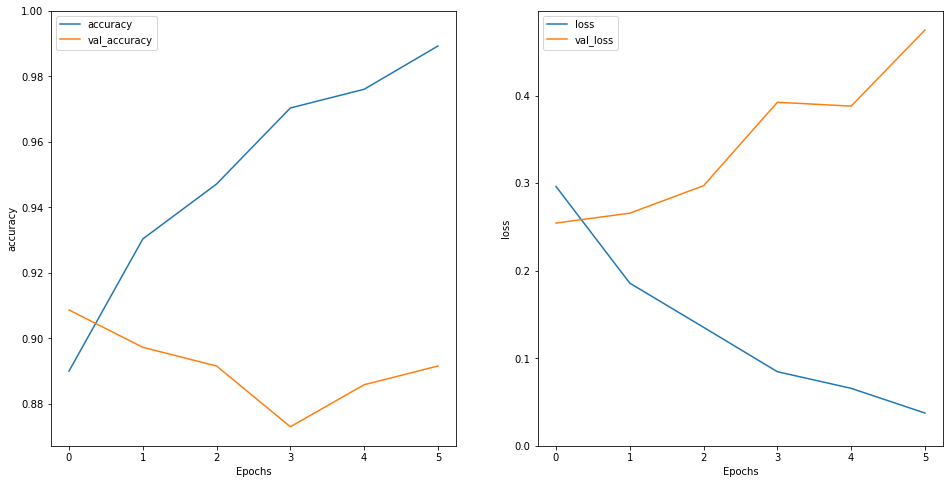

In [26]:
#Desbalanceado
all_metrics.append(pipeline_cnn_lstm("lstm_st",X_train_join[1], y_train, X_valid_join[1], y_valid, X_test_join[1], y_test))

Trial 29 Complete [00h 00m 19s]
val_accuracy: 0.8887304067611694

Best val_accuracy So Far: 0.9087018370628357
Total elapsed time: 00h 09m 44s
INFO:tensorflow:Oracle triggered exit
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 130,177
Trainable params: 130,177
Non-trainable params: 0

C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


104/104 [==============================] - 13s 51ms/step - loss: 0.3238 - accuracy: 0.8648 - val_loss: 0.2648 - val_accuracy: 0.8944
Epoch 2/50
104/104 [==============================] - 3s 30ms/step - loss: 0.1357 - accuracy: 0.9524 - val_loss: 0.3511 - val_accuracy: 0.8802
Epoch 3/50
104/104 [==============================] - 3s 29ms/step - loss: 0.0762 - accuracy: 0.9729 - val_loss: 0.4598 - val_accuracy: 0.8830
Epoch 4/50
104/104 [==============================] - 3s 29ms/step - loss: 0.0238 - accuracy: 0.9928 - val_loss: 0.6493 - val_accuracy: 0.8716
Epoch 5/50
104/104 [==============================] - 3s 28ms/step - loss: 0.0466 - accuracy: 0.9837 - val_loss: 0.6569 - val_accuracy: 0.8759
Epoch 6/50
47/47 [==============================] - 1s 11ms/step - loss: 0.7340 - accuracy: 0.8774
Test Loss: 0.7340295314788818
Test Accuracy: 0.8774150609970093
              precision    recall  f1-score   support

           0       0.42      0.29      0.35       167
           1       0.91

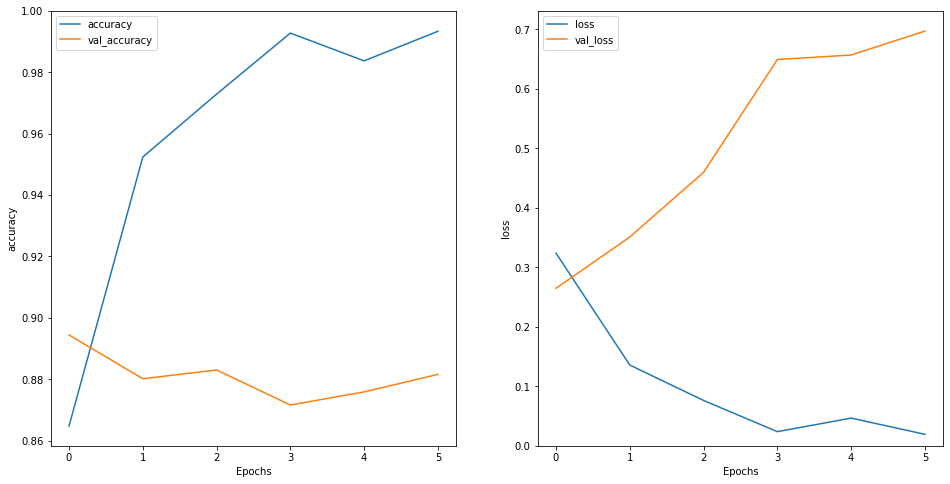

In [27]:
#Balanceado
all_metrics.append(pipeline_cnn_lstm("lstm_b_st",X_train_join_b[1], y_train_b, X_valid_join_b[1], y_valid_b, X_test_join_b[1], y_test_b))

In [28]:
df_metrics = pd.DataFrame(all_metrics, columns=['name', 'accuracy', 'f1_0', 'f1_1', 'f1_w','predictions'])
df_metrics.to_csv("metrics_lstm.csv", index= False)

### BERT

In [9]:
from transformers import TFBertForSequenceClassification
import tensorflow_addons as tfa
test = None

def pipeline_bert(name, X_train, y_train, X_valid, y_valid, X_test, y_test):

    learning_rate = 2e-5
    number_of_epochs = 3
    ds_train, ds_valid, ds_test = bert.get_bert_data(X_train, y_train, X_valid, y_valid, X_test, y_test)
    
    # model initialization
    model = TFBertForSequenceClassification.from_pretrained('bert-base-portuguese-cased', from_pt = True)

    # choosing Adam optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric_acc = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric_acc])

    #Training model
    bert_history = model.fit(ds_train, epochs=number_of_epochs, validation_data=ds_valid)
    
    #Predict test data
    result = bert.get_test_metrics(model, ds_test, y_test)

    metrics = calc_metrics(y_test, result, name)
    return metrics
    

#### Sem stemming

In [10]:
#Unbalanced data
all_metrics.append(pipeline_bert("bert", X_train_join[0], y_train, X_valid_join[0], y_valid, X_test_join[0], y_test))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification

Epoch 1/3
2801/2801 [==============================] - 799s 279ms/step - loss: 0.2956 - accuracy: 0.8854 - val_loss: 0.2723 - val_accuracy: 0.9158
Epoch 2/3
2801/2801 [==============================] - 774s 276ms/step - loss: 0.2122 - accuracy: 0.9147 - val_loss: 0.2135 - val_accuracy: 0.9130
Epoch 3/3
2801/2801 [==============================] - 776s 277ms/step - loss: 0.1600 - accuracy: 0.9429 - val_loss: 0.2927 - val_accuracy: 0.9173
              precision    recall  f1-score   support

           0       0.61      0.50      0.55       167
           1       0.94      0.96      0.95      1334

    accuracy                           0.91      1501
   macro avg       0.77      0.73      0.75      1501
weighted avg       0.90      0.91      0.90      1501

[[  83   84]
 [  53 1281]]


In [11]:
df_metrics = pd.DataFrame(all_metrics, columns=['name', 'accuracy', 'f1_0', 'f1_1', 'f1_w','predictions'])
df_metrics.to_csv("metrics_bert_1.csv", index= False)

In [10]:
#Balanced data
all_metrics.append(pipeline_bert("bert_b", X_train_join_b[0], y_train_b, X_valid_join_b[0], y_valid_b, X_test_join_b[0], y_test_b))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification

Epoch 1/3
3320/3320 [==============================] - 935s 276ms/step - loss: 0.0143 - accuracy: 0.9979 - val_loss: 7.4837 - val_accuracy: 0.1113
Epoch 2/3
3320/3320 [==============================] - 909s 274ms/step - loss: 0.0289 - accuracy: 0.9949 - val_loss: 6.6062 - val_accuracy: 0.1113
Epoch 3/3
3320/3320 [==============================] - 911s 274ms/step - loss: 0.0342 - accuracy: 0.9943 - val_loss: 6.7312 - val_accuracy: 0.1113
              precision    recall  f1-score   support

           0       0.11      1.00      0.20       167
           1       0.00      0.00      0.00      1334

    accuracy                           0.11      1501
   macro avg       0.06      0.50      0.10      1501
weighted avg       0.01      0.11      0.02      1501

[[ 167    0]
 [1334    0]]


C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
df_metrics = pd.DataFrame(all_metrics, columns=['name', 'accuracy', 'f1_0', 'f1_1', 'f1_w','predictions'])
df_metrics.to_csv("metrics_bert_2.csv", index= False)

#### Com stemming

In [10]:
#Unbalanced data
all_metrics.append(pipeline_bert("bert_st",X_train_join[1], y_train, X_valid_join[1], y_valid, X_test_join[1], y_test))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification

Epoch 1/3
2801/2801 [==============================] - 804s 281ms/step - loss: 0.3572 - accuracy: 0.8890 - val_loss: 0.3606 - val_accuracy: 0.8887
Epoch 2/3
2801/2801 [==============================] - 784s 280ms/step - loss: 0.3549 - accuracy: 0.8886 - val_loss: 0.3690 - val_accuracy: 0.8887
Epoch 3/3
2801/2801 [==============================] - 784s 280ms/step - loss: 0.3537 - accuracy: 0.8890 - val_loss: 0.3596 - val_accuracy: 0.8887
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.89      1.00      0.94      1334

    accuracy                           0.89      1501
   macro avg       0.44      0.50      0.47      1501
weighted avg       0.79      0.89      0.84      1501

[[   0  167]
 [   0 1334]]


C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
df_metrics = pd.DataFrame(all_metrics, columns=['name', 'accuracy', 'f1_0', 'f1_1', 'f1_w','predictions'])
df_metrics.to_csv("metrics_bert_3.csv", index= False)

In [10]:
#Balanced data
all_metrics.append(pipeline_bert("bert_b_st", X_train_join_b[1], y_train_b, X_valid_join_b[1], y_valid_b, X_test_join_b[1], y_test_b))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification

Epoch 1/3
3320/3320 [==============================] - 914s 270ms/step - loss: 0.0126 - accuracy: 0.9985 - val_loss: 7.6614 - val_accuracy: 0.1113
Epoch 2/3
3320/3320 [==============================] - 885s 267ms/step - loss: 0.0152 - accuracy: 0.9976 - val_loss: 7.3128 - val_accuracy: 0.1113
Epoch 3/3
3320/3320 [==============================] - 884s 266ms/step - loss: 0.0162 - accuracy: 0.9973 - val_loss: 6.8060 - val_accuracy: 0.1113
              precision    recall  f1-score   support

           0       0.11      1.00      0.20       167
           1       0.00      0.00      0.00      1334

    accuracy                           0.11      1501
   macro avg       0.06      0.50      0.10      1501
weighted avg       0.01      0.11      0.02      1501

[[ 167    0]
 [1334    0]]


C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
df_metrics = pd.DataFrame(all_metrics, columns=['name', 'accuracy', 'f1_0', 'f1_1', 'f1_w','predictions'])
df_metrics.to_csv("metrics_bert_4.csv", index= False)

#### Salvando resultados das métricas

In [48]:
df_metrics = pd.DataFrame(all_metrics, columns=['name', 'accuracy', 'f1_0', 'f1_1', 'f1_w','predictions'])
df_metrics.to_csv("metrics.csv", index= False)

In [49]:
df = pd.read_csv("metrics.csv")

In [50]:
df.head()

,name,accuracy,f1_0,f1_1,f1_w,predictions
0,rf,0.87475,0.121495,0.932568,0.842329,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


## Clustering para encontrar as reviews mais representativas

In [ ]:
df_cluster = df_pp[["reviews", "reviews_pipeline_0", "class"]]

X_join = df_cluster["reviews_pipeline_0"].apply(" ".join)
X_join = X_join.to_numpy()

vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 2000) 


bow_vec = vectorizer.fit_transform(X_join)

In [19]:
words = vectorizer.get_feature_names()

kmeans = KMeans(n_clusters = 2, random_state = 420)

kmeans.fit(bow_vec)

NameError: name 'vectorizer' is not defined

In [ ]:
kmeans.cluster_centers_

#### Achar os n mais proximos

- Reviews mais próximas do centróide da classe 0 (Ruim)

In [ ]:
n=2
d = kmeans.transform(csr_matrix.toarray(bow_vec))[:, 0] #distancia de cada ponto ao centroide 0
ind0 = np.argsort(d)[::][:n]
ind0
#csr_matrix.toarray(bow_vec)[ind]

In [ ]:
lista_neg = []
for i in ind0.tolist():
    lista_neg.append(df_pp.iloc[i]["reviews"])
lista_neg

- Reviews mais próximas do centróide da classe 1 (Bom)

In [ ]:
n = 2
d = kmeans.transform(csr_matrix.toarray(bow_vec))[:, 1] #distancia de cada ponto ao centroide 1
ind1 = np.argsort(d)[::][:n]
ind1

In [ ]:
lista_posi = []
for i in ind1.tolist():
    lista_posi.append(df_pp.iloc[i]["reviews"])
lista_posi

Salvando em um df para incluir no dashboard

In [ ]:
df_rep = pd.DataFrame(data={"negativo": lista_neg, "positivo": lista_posi})
df_rep.to_csv("reviews_rep.csv", index=False)

## Função para salvar predições do melhor classificador

In [44]:
metrics_csv = pd.read_csv("metrics.csv")
metrics_csv.head()

,name,accuracy,f1_0,f1_1,f1_w,predictions
0,rf,0.874750,0.121495,0.932568,0.842329,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,rf,0.850766,0.151515,0.918188,0.832889,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,rf_b,0.850100,0.144487,0.917853,0.831809,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,rf_st,0.850766,0.176471,0.917949,0.835452,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, ..."
4,rf_b_st,0.825450,0.170886,0.902457,0.821063,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [45]:
# metrics_csv[metrics_csv["name"]=="bert_nopp"]["predictions"]
metrics_csv["predictions"] = metrics_csv["predictions"].apply(eval)

In [59]:
metrics_csv.head(20)

,name,accuracy,f1_0,f1_1,f1_w,predictions
0,rf,0.874750,0.121495,0.932568,0.842329,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,rf,0.850766,0.151515,0.918188,0.832889,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,rf_b,0.850100,0.144487,0.917853,0.831809,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,rf_st,0.850766,0.176471,0.917949,0.835452,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, ..."
4,rf_b_st,0.825450,0.170886,0.902457,0.821063,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
5,cnn,0.877415,0.435583,0.931241,0.876094,"[[1], [1], [1], [0], [0], [1], [1], [1], [1], ..."
6,cnn_b,0.878081,0.400000,0.932147,0.872941,"[[1], [1], [1], [1], [1], [1], [1], [1], [1], ..."
7,cnn_st,0.889407,0.423611,0.938836,0.881512,"[[1], [1], [1], [1], [1], [1], [1], [1], [1], ..."
8,cnn_b_st,0.892072,0.372093,0.940962,0.877670,"[[1], [1], [1], [1], [0], [1], [1], [1], [1], ..."
9,lstm,0.869420,0.391304,0.926866,0.867280,"[[1], [1], [1], [1], [1], [1], [1], [1], [1], ..."


In [50]:
result = metrics_csv["predictions"][13]

In [40]:
#metrics_csv[metrics_csv["name"]=="bert_nopp"]["predictions"].to_numpy()

In [51]:
#X_test["pred"] = result
#df_pred = pd.merge(X_test[["class", "pred"]], df_pp[["reviews", "stars", "dates"]], left_index=True, right_index=True)
#df_pred.to_csv("best_pred.csv", index=False)



def save_results(result, X_test, df_pp, dfname="best_pred.csv"):
    X_test["pred"] = result
    df_pred = pd.merge(X_test[["class", "pred"]], df_pp[["reviews", "stars", "dates"]], left_index=True, right_index=True)
    df_pred.to_csv(dfname, index=False)

save_results(result, X_test, df_pp)

In [52]:
pd.read_csv("best_pred.csv")

,class,pred,reviews,stars,dates
0,1,1,Melhor compra que já fiz.Entrega super rápid...,5,2021-12-04
1,1,1,"Produto de primeira qualidade, fácil instala...",5,2021-11-29
2,1,1,Gostei muito do produto. Tem diversos app qu...,5,2021-06-28
3,1,0,"Não sei o que aconteceu, pode ter caido o co...",5,2021-08-27
4,1,1,O que mais gostei foi que ligando ele a TV l...,5,2021-12-10
...,...,...,...,...,...
1496,1,1,"Perfeito, o unico problema e que a minha tv ...",5,2022-01-05
1497,1,1,"Aparelho bem veloz e intuitivo, falta alguns...",5,2021-06-01
1498,0,0,"Não funciona em qualquer televisão, me senti...",2,2021-10-23
1499,1,1,"Ótimo aparelho!Fácil de manusear, instalar. ...",5,2021-12-16


In [58]:
pd.read_csv("best_pred.csv")

,class,pred,reviews,stars,dates
0,1,1,Melhor compra que já fiz.Entrega super rápid...,5,2021-12-04
1,1,1,"Produto de primeira qualidade, fácil instala...",5,2021-11-29
2,1,1,Gostei muito do produto. Tem diversos app qu...,5,2021-06-28
3,1,0,"Não sei o que aconteceu, pode ter caido o co...",5,2021-08-27
4,1,1,O que mais gostei foi que ligando ele a TV l...,5,2021-12-10
...,...,...,...,...,...
1496,1,1,"Perfeito, o unico problema e que a minha tv ...",5,2022-01-05
1497,1,1,"Aparelho bem veloz e intuitivo, falta alguns...",5,2021-06-01
1498,0,0,"Não funciona em qualquer televisão, me senti...",2,2021-10-23
1499,1,1,"Ótimo aparelho!Fácil de manusear, instalar. ...",5,2021-12-16
